# Table of Contents
 <p>

In [8]:
import numpy as np
import matplotlib . pyplot as plt
import seaborn as sns

%matplotlib inline

# Useful functions for integration
def f(p):
    return 1.0 / (1.0 + p **2)

def dp_dt (m, p, gamma_p, beta):
    return gamma_p *(beta*m - p)

def dm_dt (m, p, gamma_m):
    return gamma_m *(f(p) - m)

# Function to perform solution
def solve_her_one_oscillator (
    gamma_p =20.0, gamma_m =20.0, beta =3.0, dt =0.001, t_stop =30.0):

    # Number of indices to go back for a time unit ( useful for delays )
    i_time = int(1/dt)

    # Time points ( start -1 time unit so we can handle delays )
    t = np.linspace ( -1 , t_stop , (1 + t_stop ) / dt )

    # Initialize output arrays
    m = np.zeros_like( t)
    p = np.zeros_like( t)

    # Do Euler stepping
    for i in range ( i_time , len (t ) -1) :
        m[i +1] = m [i] + dt * dm_dt ( m[i], p[ i - i_time ] , gamma_m )
        p[i +1] = p [i] + dt * dp_dt ( m[i], p[ i], gamma_p , beta )

    return t , m , p



In [9]:
# Run the calculations for small and large gamma
t , m_small , p_small = solve_her_one_oscillator(gamma_p =2.0 , gamma_m =2.0 ,
t_stop =25.0)
t , m_large , p_large = solve_her_one_oscillator(gamma_p =20.0 , gamma_m =20.0 ,
t_stop =25.0)


/Users/dangeles/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


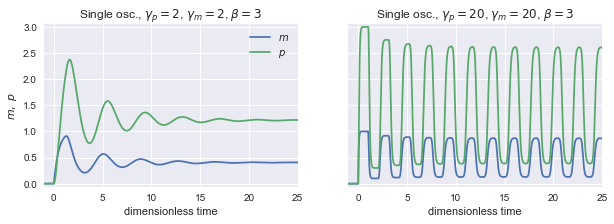

In [19]:
# Plot result and save
fig, ax = plt.subplots(1 , 2, figsize =(10 ,3) , sharey = True )
ax[0].plot(t , m_small , t , p_small , ls= '-')
ax[1].plot(t , m_large , t , p_large , '-')
ax[0].set_xlabel('dimensionless time')
ax[1].set_xlabel('dimensionless time')
ax[0].legend(( '$m$', '$p$') , loc ='upper right')
ax[0].set_xlim(( t.min() , t.max() ) )
ax[1].set_xlim(( t.min() , t.max() ) )
ax[0].margins(y =0.02)
ax[0].set_ylabel('$m ,\; p$')
ax[0].set_title(r'Single osc., $\gamma_p = 2$, $\gamma_m = 2$, $\beta = 3$')
ax[1].set_title(r'Single osc., $\gamma_p = 20$, $\gamma_m = 20$, $\beta = 3$')
plt.savefig('single_oscillator.pdf', bbox_inches ='tight')